In [4]:
import torch
from scipy.io import loadmat
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch import nn
from tkinter import filedialog
import tkinter as tk
from neurorobotics_dl.utils import MyDataset,summary,get_class
from neurorobotics_dl.trainer import MyTrainer

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt

import os
from neurorobotics_dl.processing import read_gdf, filter_data
from joblib import dump,load
from datetime import date,time

class Event():
    START = 1
    CONT_FEEDBACK = 781
    FIXATION = 786
    HIT = 897
    MISS = 898
    TIMEOUT = 899
    REST = 700
    LEFT_ALIGNMENT_STEP = 701
    LEFT_STEP = 702
    RIGHT_ALIGNMENT_STEP = 703
    RIGHT_STEP = 704
    MOVEMENT_START = 333
    CVSA_LEFT = 730
    CVSA_RIGHT = 731
    LEFT_HAND = 769
    RIGHT_HAND = 770    
    BOTH_FEET = 771
    BOTH_HANDS = 773
    REST = 783
    OFFSET = 0X8000

def select_files(initialdir='./recordings'):
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filenames = []
    while True:
       new_names = filedialog.askopenfilenames(initialdir=initialdir,defaultextension='gdf')
       if not new_names:
           break
       filenames.extend(new_names) 
    return filenames

def create_windows(eeg, events, window_size, window_shift,start_after = 0,end_before = 0):
    windows,winlabels = [],[]
    for _,row in tqdm(events.iterrows(),leave=False,total=len(events)):
        start,stop = row['POS'] + start_after, row['POS']+row['DUR'] - end_before
        if type(window_shift) == dict:
            shift = window_shift[row['label']]
        else: 
            shift = window_shift
        while start+window_size < stop:
            winlabels.append(row['label'])
            windows.append(eeg[start:start+window_size])
            start+=shift
    windows = np.stack(windows)
    windows = torch.from_numpy(windows).float().unsqueeze(1).permute(0,1,3,2)  
    winlabels = torch.tensor(winlabels).long()

    return windows,winlabels

def predict_all(model,dataloader,device):
    model.eval()

    model.to(device)
    logits = []
    labels = []
    with torch.no_grad():
            
        for x,y in tqdm(dataloader):
            x = x.to(device)
            out = model(x)
            logits.append(out)
            labels.append(y)
        logits = torch.vstack(logits).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()
        return logits,labels

def show_results(model,dataloader,device,criterion=torch.nn.CrossEntropyLoss(),ax=None):
    logits,labels = predict_all(model,dataloader,device)
    acc = (logits.argmax(axis=1) == labels).mean()
    loss = criterion(torch.from_numpy(logits),torch.from_numpy(labels)).item()
    f1 = f1_score(labels,logits.argmax(axis=1),average='macro')
    print("F1: {:.2f}% | Acc: {:.2f}% | Loss: {}".format(f1*100,acc*100,loss))
    cm = confusion_matrix(labels,logits.argmax(axis=1))
    ConfusionMatrixDisplay(cm).plot(ax=ax)


def preprocess(filenames,save_path=None):
    eegs = []
    all_events = []
    last_eeg_len = 0
    fileno = 0
    for filename in filenames:        
        try:

            tqdm.write(str(fileno)+ " - "+ filename.split('/')[-2]+" - "+filename.split('/')[-1], end = ' - ')
            extras = filename.split('/')[-1].split('.')
            
            
            recording = read_gdf(filename,drop_chans=['sens1','Status','trigger:1'])
            
            eeg = recording['data']
            info = recording['info']
            subj = info['subject_info']['his_id']
            dat = info['meas_date']
            mode = extras[3]
            protocol = extras[4]
            fs = info['sfreq'] 
            events = recording['events']

            eeg = filter_data(eeg, fs,fc_bp=[2,40])
            events['POS'] += last_eeg_len
            events['FILENO'] = fileno
            events['FILENAME'] = filename.split('/')[-1]
            events['SUBJ'] = subj
            events['DATE'] = dat
            events['MODE'] = mode
            events['PROTOCOL'] = protocol

        except Exception as e:
            print(f"Error: {e} - Skipping file..")
            continue

        eegs.append(eeg)
        fileno += 1
        all_events.append(events)
        last_eeg_len += len(eeg)
        print("Loaded.")
        
    eegs = np.concatenate(eegs)
    all_events = pd.concat(all_events)

    preprocessed = {'data':eegs,
                    'events':all_events,
                    'info': info
                }
    
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        dump(preprocessed,os.path.join(save_path,f'preprocessed.pkl'))
    
    
    return preprocessed

In [23]:
MANUAL_PICK = True
SAVE_PATH=r'D:\SHARED\PhD\code\python\cache'
if MANUAL_PICK:
    filenames = select_files(r'D:\SHARED\PhD\data\mi_bhbf')
    if not filenames:
        print('No files selected! Nothing to preprocess!')
    else: dataset = preprocess(filenames,SAVE_PATH)
else:
    dataset = load(os.path.join(SAVE_PATH,f"preprocessed.pkl"))

0 - mi_bhbf - d7.20260129.094532.calibration.mi_bhbf.gdf - Loaded.
1 - mi_bhbf - d7.20260129.094907.calibration.mi_bhbf.gdf - Loaded.
2 - mi_bhbf - d7.20260129.095455.evaluation.mi_bhbf.gdf - Loaded.


In [26]:
out_path = "models"

model_name = "generic_wheel"
model_path = os.path.join(out_path,model_name)
if not os.path.isdir(model_path):
    os.makedirs(model_path)

train_batch_size = 128
eval_batch_size = 256
device = 'cuda'

label_map = { # PUT ALL THE CUE CODES HERE OTHERWISE IT FAILS, -1 TO IGNORE  
  Event.CVSA_LEFT: -1,  
  Event.CVSA_RIGHT: -1,   
  Event.BOTH_FEET: 0,  
  Event.BOTH_HANDS: 1,  
  Event.LEFT_HAND: -1,  
  Event.RIGHT_HAND: -1,  
  Event.REST: -1
  }
num_classes = np.unique(list(label_map.values())).shape[0]
window_size = 512
window_shift = {
    0:32,
    1:32,
  }
start_after = 256
end_before = 256

eeg = dataset['data']

# from neurorobotics_dl.utils import fidx
# ROI = ['P3','PZ','P4','PO7','PO5','PO3','POZ','PO4','PO6','O1','OZ','O2']
# eeg = eeg[:,fidx(ROI, dataset['info']['ch_names'])]


events = dataset['events']
num_channels = eeg.shape[1]

labels = events['TYP'].map(label_map).dropna().values.astype(int)


cf_events = events[events['TYP'] == Event.CONT_FEEDBACK].copy()
cf_events['label'] = labels
cf_events = cf_events[cf_events['label'] >= 0].reset_index(drop=True)
cf_events

,TYP,POS,DUR,FILENO,FILENAME,SUBJ,DATE,MODE,PROTOCOL,label
0,781,2860,2320,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,1
1,781,7791,2586,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,0
2,781,12989,2401,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,1
3,781,18001,2499,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,0
4,781,23112,2396,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,0
5,781,28120,2171,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,1
6,781,32902,2366,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,1
7,781,37879,2591,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,1
8,781,43082,2550,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,0
9,781,48243,2314,0,d7.20260129.094532.calibration.mi_bhbf.gdf,d7,2026-01-29 08:45:35.000005+00:00,calibration,mi_bhbf,0


In [29]:
## Choose one between 70-15-15 split or manual selecting files. comment the other

## 70-15-15 split
#train_files = range(len(filenames))
#train_events = trial_events[trial_events['FILENO'].isin(train_files)]
#val_events = train_events[int(len(train_events)*0.7):int(len(train_events)*0.85)]
#test_events = train_events[int(len(train_events)*0.85):]
#train_events = train_events[:int(len(train_events)*0.7)]

# ## Separate sessions
train_files = [0,1]
val_files = [1]
test_files = [2]
train_events = cf_events[cf_events['FILENO'].isin(train_files)]
val_events = cf_events[cf_events['FILENO'].isin(val_files)]
test_events = cf_events[cf_events['FILENO'].isin(test_files)]


#Create datasets and dataloaders
train_w,train_l = create_windows(eeg, train_events, window_size, window_shift,start_after,end_before)
val_w,val_l = create_windows(eeg, val_events, window_size, window_shift,start_after,end_before)
test_w,test_l = create_windows(eeg, test_events, window_size, window_shift,start_after,end_before)

# Apply standardization
mu,sigma = train_w.mean(axis = (0,1,3),keepdims=True),train_w.std(axis = (0,1,3),keepdims=True)
train_w = (train_w - mu) / sigma
val_w = (val_w - mu) / sigma
test_w = (test_w - mu) / sigma


np.savez(os.path.join(model_path,"mean_std.npz"),mu=mu,sigma=sigma)

for e in (torch.unique(train_l,return_counts=True),
torch.unique(val_l,return_counts=True),
torch.unique(test_l,return_counts=True)): print(e)

train_loader = DataLoader(MyDataset(train_w,train_l), batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(MyDataset(val_w,val_l), batch_size=eval_batch_size, shuffle=False)
test_loader = DataLoader(MyDataset(test_w,test_l), batch_size=eval_batch_size, shuffle=False)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

(tensor([0, 1]), tensor([893, 897]))
(tensor([0, 1]), tensor([449, 449]))
(tensor([0, 1]), tensor([277, 257]))


In [30]:
# # EEGNET
model_config = {
  'classname': 'neurorobotics_dl.models.EEGNet',
  'options': {
    'nb_classes': num_classes,
    'Chans': num_channels,
    'Samples': window_size,
    'dropoutRate': 0.5,
    'kernLength': window_size//2,
    'F1': 8,
    'D': 2,
    'F2': 16
  }
}


# # TGCN
# model_config = {
#   'classname': 'neurorobotics_dl.models.GCN_GRU_sequence_fxdD',
#   'options': { 'num_channels': num_channels,
#                'gcn_input_dim' : num_channels,
#                'num_classes' : num_classes,
#                'gcn_output_dim' : 16,
#                'gru_hidden_units' : 16,
#                'gcn_dropout' : 0.3,
#                'gru_dropout' : 0.3
#   }
# }

# # GRU
# model_config = {
#   'classname': 'models.RNN',
#   'options': { 'input_size': 32,
#                'num_classes' : num_classes,
#                'hidden_size' : 128,
#                'num_layers' : 1,
#   }
# }

# # PhiNet
# model_config = {
#   'classname': ' micromind.networks.PhiNet',
#   'options': {'input_shape':(1, num_channels, window_size),
#                'num_classes':num_classes,
#                'num_layers' : 6,
#                'alpha':0.5,
#                'beta':2,
#                't_zero':1.5,
#                'include_top':True
# }
# }

# # AttentionNet
# model_config = {
#   'classname': 'models.AttentionNet',
#   'options': { 'num_channels':32,
#                'num_classes':num_classes,
#                'num_heads':1,
#                'hidden_size':128,
#                'enforce_simmetry':True
#   }
# }

# # EEGTransformer
# model_config = {
#   'classname': 'neurorobotics_dl.models.EEGTransformer',
#   'options': { 'd_model' : 32, 
#               'embedding_dim' : 2, 
#               'encoder_layer_args':{'nhead':4,'batch_first':True},
#               'encoder_args':{'num_layers':2},
#   }
# }


model = get_class(model_config['classname'])(**model_config['options']).to(device)

summary(model)
class WeightClipper(object):
    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'Wa'):
            module.Wa.data.clamp_(0,1)

Model Parameters:
+-------------------+--------+-----------------------------+-----------+
|       Layer       | Params |            Shape            | Trainable |
+-------------------+--------+-----------------------------+-----------+
|    conv.weight    |  2048  |  torch.Size([8, 1, 1, 256]) |    True   |
|     bn1.weight    |   8    |       torch.Size([8])       |    True   |
|      bn1.bias     |   8    |       torch.Size([8])       |    True   |
| depth_conv.weight |  256   |  torch.Size([16, 1, 16, 1]) |    True   |
|     bn2.weight    |   16   |       torch.Size([16])      |    True   |
|      bn2.bias     |   16   |       torch.Size([16])      |    True   |
| point_conv.weight |  4096  | torch.Size([16, 16, 1, 16]) |    True   |
|     bn3.weight    |   16   |       torch.Size([16])      |    True   |
|      bn3.bias     |   16   |       torch.Size([16])      |    True   |
|     fc.weight     |  768   |     torch.Size([3, 256])    |    True   |
|      fc.bias      |   3    |   

In [31]:
from torch.optim import Adam,AdamW,SGD
from neurorobotics_dl.losses import AdaptiveFocalLoss
model = get_class(model_config['classname'])(**model_config['options']).to(device)


optimizer = Adam(model.parameters(),lr = 0.001,weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,1,0.1,100)
# criterion = nn.CrossEntropyLoss()
criterion = AdaptiveFocalLoss()


model = model.to(device)
"""   TRAIN   """
trainer = MyTrainer(model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    es_patience=0,
                    es_min_delta=0,
                    # contraints=WeightClipper()
                    )

trainer.train( 60,
                criterion,
                train_loader,
                val_loader,
                logger_name=os.path.join(model_path,"training.log"),
                device = device,
                path=model_path,
                )

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/60	 Train Loss: 0.4358485792602241, Train Acc: 0.436312853291048, Val Loss: 0.3735549222918555, Val Acc: 0.514476618018076
New best loss achieved: 0.3735549222918555


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/60	 Train Loss: 0.29317966599704165, Train Acc: 0.49217877294764173, Val Loss: 0.28291157760837826, Val Acc: 0.5289532286021651
New best loss achieved: 0.28291157760837826


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/60	 Train Loss: 0.23555209277062442, Train Acc: 0.5173184357541899, Val Loss: 0.23774310355728082, Val Acc: 0.5311804032803644
New best loss achieved: 0.23774310355728082


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/60	 Train Loss: 0.21698252264014836, Train Acc: 0.5145251419624137, Val Loss: 0.20977199280049594, Val Acc: 0.521158132361941
New best loss achieved: 0.20977199280049594


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/60	 Train Loss: 0.20923531544941099, Train Acc: 0.5122905047246198, Val Loss: 0.1947469604606087, Val Acc: 0.5178173737961359
New best loss achieved: 0.1947469604606087


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/60	 Train Loss: 0.1992880500062218, Train Acc: 0.4972067039106145, Val Loss: 0.1866867385290248, Val Acc: 0.5478841892064016
New best loss achieved: 0.1866867385290248


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/60	 Train Loss: 0.19257627064622315, Train Acc: 0.5234636912132775, Val Loss: 0.18188412927240466, Val Acc: 0.566815142509401
New best loss achieved: 0.18188412927240466


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/60	 Train Loss: 0.1911255882938481, Train Acc: 0.5150838028785236, Val Loss: 0.17723907210048961, Val Acc: 0.5712694913348004
New best loss achieved: 0.17723907210048961


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/60	 Train Loss: 0.18760527129279836, Train Acc: 0.5217877134930489, Val Loss: 0.1728740005789196, Val Acc: 0.5634743867313411
New best loss achieved: 0.1728740005789196


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/60	 Train Loss: 0.18670211769016096, Train Acc: 0.5329608976507986, Val Loss: 0.1694484340454263, Val Acc: 0.6191536748329621
New best loss achieved: 0.1694484340454263


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/60	 Train Loss: 0.1829472260268707, Train Acc: 0.5491620131045081, Val Loss: 0.16698127565179477, Val Acc: 0.6547884187746155
New best loss achieved: 0.16698127565179477


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/60	 Train Loss: 0.17849301161379788, Train Acc: 0.5893854785897878, Val Loss: 0.16374850225010534, Val Acc: 0.6815144774775728
New best loss achieved: 0.16374850225010534


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/60	 Train Loss: 0.1735745991408492, Train Acc: 0.589385476458672, Val Loss: 0.15921274954266432, Val Acc: 0.6982182638682342
New best loss achieved: 0.15921274954266432


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/60	 Train Loss: 0.16969611310093097, Train Acc: 0.6145251434608545, Val Loss: 0.15264000315509554, Val Acc: 0.7260579075207955
New best loss achieved: 0.15264000315509554


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/60	 Train Loss: 0.1598043422459224, Train Acc: 0.6709497238670648, Val Loss: 0.13875605467964122, Val Acc: 0.7984409796899571
New best loss achieved: 0.13875605467964122


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/60	 Train Loss: 0.15036504937949793, Train Acc: 0.7150838040772763, Val Loss: 0.12542026717307042, Val Acc: 0.7817371944276686
New best loss achieved: 0.12542026717307042


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/60	 Train Loss: 0.1440841067436687, Train Acc: 0.7424581056866566, Val Loss: 0.10828698559234827, Val Acc: 0.8195991095960273
New best loss achieved: 0.10828698559234827


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/60	 Train Loss: 0.12996382924764516, Train Acc: 0.7949720700359877, Val Loss: 0.09791305837094917, Val Acc: 0.8374164812017921
New best loss achieved: 0.09791305837094917


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/60	 Train Loss: 0.11857187507372328, Train Acc: 0.807262572696089, Val Loss: 0.08693893262100114, Val Acc: 0.8474387529167141
New best loss achieved: 0.08693893262100114


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/60	 Train Loss: 0.1153251724952426, Train Acc: 0.8122905056569829, Val Loss: 0.07791084555581311, Val Acc: 0.8418708244517014
New best loss achieved: 0.07791084555581311


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/60	 Train Loss: 0.10417071481823255, Train Acc: 0.8446927400940624, Val Loss: 0.06669625166994426, Val Acc: 0.8730512289268136
New best loss achieved: 0.06669625166994426


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/60	 Train Loss: 0.10272408538191012, Train Acc: 0.8413407846536051, Val Loss: 0.06324728120342395, Val Acc: 0.8853006673549491
New best loss achieved: 0.06324728120342395


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/60	 Train Loss: 0.09869621848926864, Train Acc: 0.8491620139702738, Val Loss: 0.058826626210010925, Val Acc: 0.9053452142362871
New best loss achieved: 0.058826626210010925


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/60	 Train Loss: 0.08691347312993844, Train Acc: 0.8787709523845652, Val Loss: 0.051896463075698354, Val Acc: 0.9008908674021341
New best loss achieved: 0.051896463075698354


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/60	 Train Loss: 0.081542033539804, Train Acc: 0.8737430215547871, Val Loss: 0.0447940192038073, Val Acc: 0.9253897567368828
New best loss achieved: 0.0447940192038073


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/60	 Train Loss: 0.07765327809409722, Train Acc: 0.8882681610863968, Val Loss: 0.03576887292758393, Val Acc: 0.9220489959143318
New best loss achieved: 0.03576887292758393


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/60	 Train Loss: 0.07098463234288732, Train Acc: 0.8972067085724303, Val Loss: 0.03281173860044416, Val Acc: 0.9354120247348114
New best loss achieved: 0.03281173860044416


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/60	 Train Loss: 0.06825217710776701, Train Acc: 0.8938547530653757, Val Loss: 0.030031394678062213, Val Acc: 0.9476614720571811
New best loss achieved: 0.030031394678062213


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/60	 Train Loss: 0.06618936185064263, Train Acc: 0.9100558705836035, Val Loss: 0.025147992619759255, Val Acc: 0.965478843065572
New best loss achieved: 0.025147992619759255


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/60	 Train Loss: 0.06953237174942507, Train Acc: 0.903351959902481, Val Loss: 0.022009428258661704, Val Acc: 0.961024496231419
New best loss achieved: 0.022009428258661704


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/60	 Train Loss: 0.06649675936172794, Train Acc: 0.9089385500833309, Val Loss: 0.02195391618130202, Val Acc: 0.9788418709568032
New best loss achieved: 0.02195391618130202


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/60	 Train Loss: 0.05666985694922549, Train Acc: 0.9223463733768996, Val Loss: 0.025364154099356093, Val Acc: 0.942093539875175


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/60	 Train Loss: 0.06045465148028049, Train Acc: 0.9122905052573987, Val Loss: 0.0164253442052478, Val Acc: 0.9810690387320147
New best loss achieved: 0.0164253442052478


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/60	 Train Loss: 0.06096810963233756, Train Acc: 0.9094972092346106, Val Loss: 0.021981272713710576, Val Acc: 0.9732739426245403


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/60	 Train Loss: 0.05217589442540147, Train Acc: 0.9296089430095097, Val Loss: 0.014498367777015424, Val Acc: 0.988864142804475
New best loss achieved: 0.014498367777015424


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/60	 Train Loss: 0.05261342948791701, Train Acc: 0.9262569875690524, Val Loss: 0.01672190259353886, Val Acc: 0.9699331820674888


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/60	 Train Loss: 0.052047356401242355, Train Acc: 0.9312849185320252, Val Loss: 0.017317774508538383, Val Acc: 0.9755011146477442


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/60	 Train Loss: 0.05052641993544621, Train Acc: 0.9379888313442635, Val Loss: 0.013264200863799699, Val Acc: 0.9922049000427824
New best loss achieved: 0.013264200863799699


  0%|          | 0/14 [00:00<?, ?it/s]

Training interrupted


Train: 


C:\Users\tomma\AppData\Local\Temp\ipykernel_29184\1291630086.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path,"Be

  0%|          | 0/14 [00:00<?, ?it/s]

F1: 99.39% | Acc: 99.39% | Loss: 0.20048122107982635
Val: 


  0%|          | 0/4 [00:00<?, ?it/s]

F1: 99.22% | Acc: 99.22% | Loss: 0.1899665892124176
Test: 


  0%|          | 0/3 [00:00<?, ?it/s]

F1: 96.25% | Acc: 96.25% | Loss: 0.2250594198703766


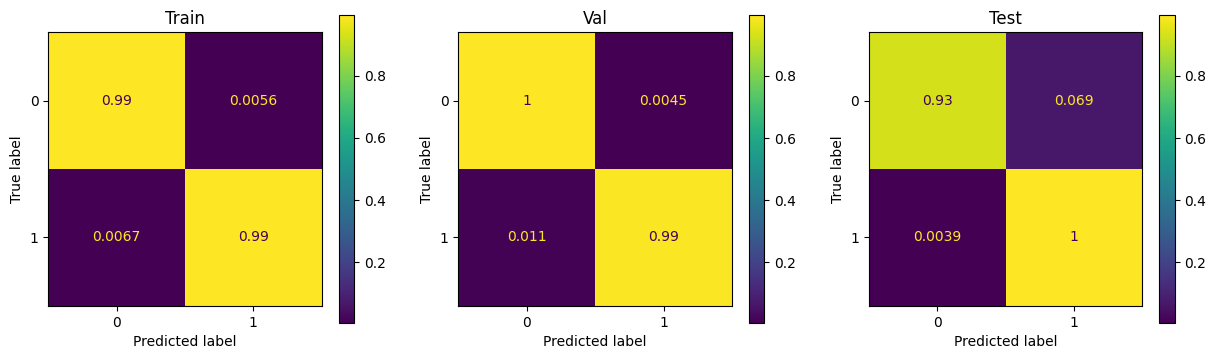

In [32]:
model.load_state_dict(torch.load(os.path.join(model_path,"BestModel/best-model.pt"))['model' ])
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_size_inches(15, 4)

def show_results(model,dataloader,device,criterion=torch.nn.CrossEntropyLoss(),ax=None):
    logits,labels = predict_all(model,dataloader,device)
    acc = (logits.argmax(axis=1) == labels).mean()
    loss = criterion(torch.from_numpy(logits),torch.from_numpy(labels)).item()
    f1 = f1_score(labels,logits.argmax(axis=1),average='macro')
    print("F1: {:.2f}% | Acc: {:.2f}% | Loss: {}".format(f1*100,acc*100,loss))
    cm = confusion_matrix(labels,logits.argmax(axis=1),normalize='true')
    ConfusionMatrixDisplay(cm).plot(ax=ax)

print("Train: "),show_results(model,train_loader,device,ax=ax1)
print("Val: "),show_results(model,val_loader,device,ax=ax2)
print("Test: "),show_results(model,test_loader,device,ax=ax3)
ax1.set_title("Train")
ax2.set_title("Val")
ax3.set_title("Test")

plt.show()

In [33]:
state_dict = torch.load(os.path.join(model_path,"BestModel/best-model.pt"))
mu_sigma = np.load(os.path.join(model_path,"mean_std.npz"))
state_dict['mu'] = mu_sigma['mu']
state_dict['sigma'] = mu_sigma['sigma']
state_dict['config'] = model_config
state_dict['classes'] = label_map
state_dict['filenames'] = cf_events[cf_events['FILENO'].isin(train_files)]['FILENAME'].drop_duplicates().values
torch.save(state_dict,os.path.join(model_path,f"{model_name}.pt"))

C:\Users\tomma\AppData\Local\Temp\ipykernel_29184\3762033038.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(model_path,"BestModel/b

## Analysis

In [34]:
from neurorobotics_dl.utils import load_checkpoint

model_path = os.path.join(model_path,f'{model_name}.pt')
# model_path = '/home/whiteam/Desktop/exo_training/c8_exo/c8_exo.pt'
# state_dict = torch.load(model_path)

load_checkpoint(model_path)
model = get_class(state_dict['config']['classname'])(**state_dict['config']['options'])
model.load_state_dict(state_dict['model'])
mu,sigma = state_dict['mu'],state_dict['sigma']

D:\SHARED\PhD\code\python\neurorobotics-dl\neurorobotics_dl\utils.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = load(model_ckpt)


In [35]:
all_logits = []
all_labels = []
dfs = []
device = 'cuda'
eval_batch_size = 512

window_size = 512
window_shift = 16

t_events = cf_events[cf_events['FILENO'].isin([3])]
t_events = cf_events

for fileno in t_events['FILENO'].unique():
    print(fileno)
    ev = t_events[t_events['FILENO']==fileno]

    test_w,test_l = create_windows(eeg, ev, window_size, window_shift)
    test_w = (test_w - mu) / sigma
    test_loader = DataLoader(MyDataset(test_w,test_l), batch_size=eval_batch_size, shuffle=False)
    logits,labels = predict_all(model,test_loader,device)

    df = pd.DataFrame({'logits':logits.tolist(),
                       'preds':logits.argmax(axis=1).tolist(),
                       'labels':labels.tolist()})
    df['FILENO'] = fileno
    df['MODE'] = ev['MODE'].iloc[0]
    dfs.append(df)

results = pd.concat(dfs)

0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

2


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

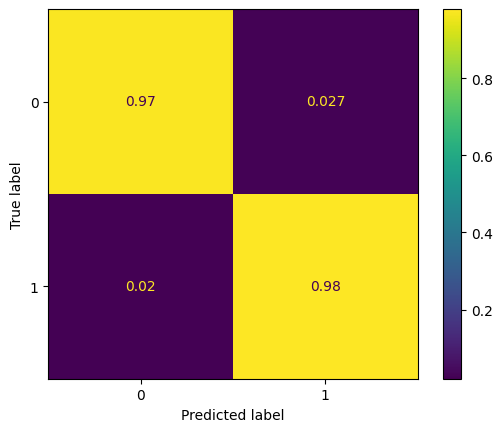

In [36]:
ConfusionMatrixDisplay(confusion_matrix(results['labels'],results['preds'],normalize='true')).plot()

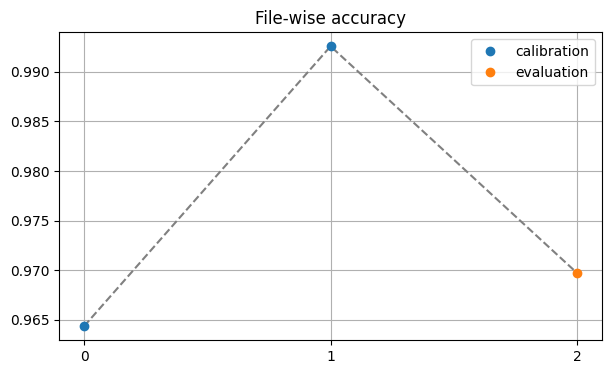

In [37]:
results['correct'] = results['labels'] == results['preds']
acc = results.groupby('FILENO')['correct'].mean().values

modes = results.groupby('FILENO').first()['MODE'].values


files = results.groupby('FILENO')['FILENO'].first().values
plt.figure(figsize=(7,4))
plt.title('File-wise accuracy')
plt.plot(files,acc,linestyle='--',color='gray')
for mode in np.unique(modes):
    plt.plot(files[modes==mode],acc[modes==mode],marker='o',linestyle='None',label=f'{mode}')
plt.xticks(files,files)
plt.grid()
plt.legend()
plt.show()

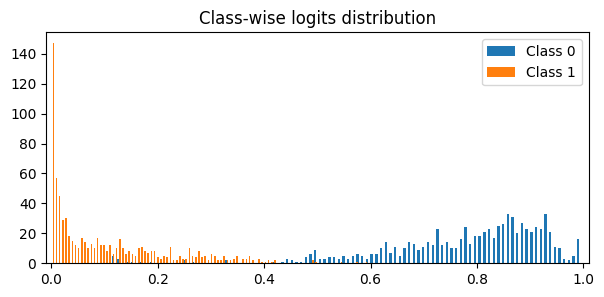

In [40]:
res = results[results.FILENO==2]
all_logits = np.stack(res['logits'].values)[:,:2]
# all_logits = minmax_scale(all_logits)
all_logits = torch.softmax(torch.from_numpy(all_logits),1).numpy()
# all_logits = (all_logits-(np.min(all_logits,axis=0)))/(np.max(all_logits,axis=0)-np.max(all_logits,axis=0))
labels = res['labels']

plt.figure(figsize=(7,3))
for i in range(all_logits.shape[1]):
    plt.hist(all_logits[labels==i][:,0],bins=100,rwidth=0.5,label=f'Class {i}')
plt.title('Class-wise logits distribution')
plt.legend()
plt.xlim(-0.01,1.01)
plt.show()